In [1]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy
import cf_units

In [2]:
# change to your suite-id to pick up the required file
runid='cq988'
# this is the grid we want to regrid to, e.g. N48 ENDGame
datafile='/home/vagrant/cylc-run/u-'+runid+'/work/1/atmos/atmosa.pa19810901_00'

In [3]:
# read-in raw emissions data
emiss=iris.load_cube('/home/vagrant/Tutorials/UMvn13.0/Task08.1/Emissions_of_ALICE.nc')
# make intersection between 0 and 360 longitude to ensure that 
# the data is regridded correctly
nemiss = emiss.intersection(longitude=(0, 360))

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


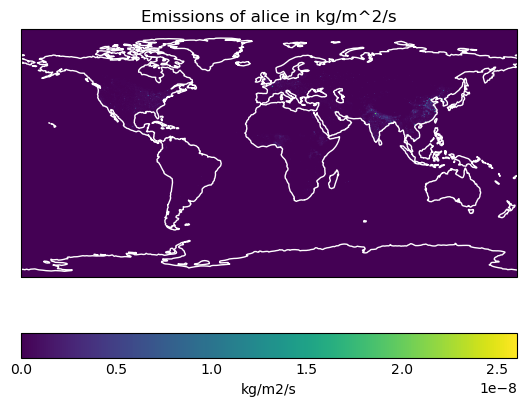

In [4]:
qplt.pcolormesh(nemiss[0,:,:])
plt.gca().coastlines(color='w')

In [5]:
# read-in a UKCA field from our model output - take O3 as basic shape
indata=iris.load_cube(datafile,iris.AttributeConstraint(STASH='m01s34i001'))
# guess the bounds of the grid file
indata.coord(axis='x').guess_bounds()
indata.coord(axis='y').guess_bounds()

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/pp.py:1562: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t1 = cftime.datetime(
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/pp.py:1597: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t2 = cftime.datetime(
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cf_units/__init__.py:402: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  dates = np.array([dt and dt.replace(microsecond=0) for dt in dates])
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/rules.py:353: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))


In [6]:
# make sure that we use the same coordinate system, otherwise regrid won't work
nemiss.coord(axis='x').coord_system=indata.coord_system()
nemiss.coord(axis='y').coord_system=indata.coord_system()
# now guess the bounds of the new grid prior to regridding
nemiss.coord(axis='x').guess_bounds()
nemiss.coord(axis='y').guess_bounds()

In [7]:
# now regrid to the supplied O3 grid using area weighted regridding
emiss_regrid=nemiss.regrid(indata,iris.analysis.AreaWeighted())

/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ubuntu/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


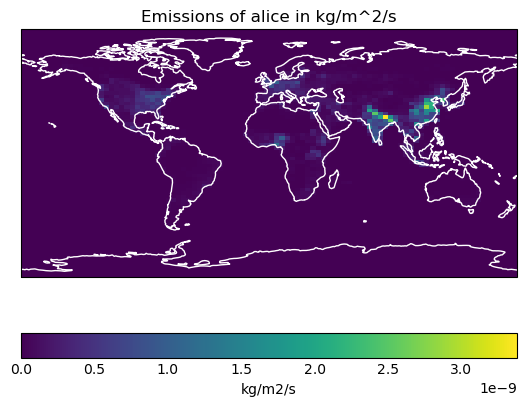

In [8]:
qplt.pcolormesh(emiss_regrid[0,:,:])
plt.gca().coastlines(color='w')

In [9]:
# now add correct attributes and names to netCDF file
emiss_regrid.var_name='emissions_ALICE'
emiss_regrid.long_name='ALICE surf emissions'
emiss_regrid.units=cf_units.Unit('kg m-2 s-1')
emiss_regrid.attributes['vertical_scaling']='surface'
emiss_regrid.attributes['tracer_name']='ALICE'
# global attributes, so don't set in local_keys
# NOTE: all these should be strings, including the numbers!
# basic emissions type
emiss_regrid.attributes['update_type']='2'   # same as above
emiss_regrid.attributes['update_freq_in_hours']='120' # i.e. 5 days

In [10]:
# time dimension
# rename and set time coord - set to be 0000/01/16:00:00-0000/12/16:00:00
emiss_regrid.coord(axis='t').var_name='time'
emiss_regrid.coord(axis='t').standard_name='time'
emiss_regrid.coords(axis='t')[0].units=cf_units.Unit('hours since 1970-01-01', calendar='360_day')
emiss_regrid.coord(axis='t').points=numpy.array([-17020440, -17019720, -17019000, -17018280,
                                          -17017560, -17016840, -17016120, -17015400, 
                                          -17014680, -17013960, -17013240, -17012520])

In [11]:
# make z-direction.
zdims=iris.coords.DimCoord(numpy.array([0]),standard_name = 'model_level_number',
                           units='1',attributes={'positive':'up'})
emiss_regrid.add_aux_coord(zdims)
emiss_regrid=iris.util.new_axis(emiss_regrid, zdims)
# now transpose cube to put Z 2nd
emiss_regrid.transpose([1,0,2,3])

In [12]:
# set _FillValue
fillval=1e+20
emiss_regrid.data = numpy.ma.array(data=emiss_regrid.data, fill_value=fillval)

In [13]:
# make coordinates 64-bit
emiss_regrid.coord(axis='x').points=emiss_regrid.coord(axis='x').points.astype(dtype='float64')
emiss_regrid.coord(axis='y').points=emiss_regrid.coord(axis='y').points.astype(dtype='float64')
emiss_regrid.coord(axis='t').points=emiss_regrid.coord(axis='t').points.astype(dtype='float64')
emiss_regrid.coord('latitude').bounds=emiss_regrid.coord('latitude').bounds.astype(dtype='float64')

In [14]:
# now write-out the file
# output file name, based on species
outpath='/home/vagrant/iris_ukca_emiss_ALICE.nc'
# annoying hack to set a missing_value attribute as well as a _FillValue attribute
dict.__setitem__(emiss_regrid.attributes, 'missing_value', fillval)
# now write-out to netCDF
saver = iris.fileformats.netcdf.Saver(filename=outpath, netcdf_format='NETCDF3_CLASSIC')
saver.update_global_attributes(Conventions=iris.fileformats.netcdf.CF_CONVENTIONS_VERSION)
saver.write(emiss_regrid, local_keys=['vertical_scaling', 'missing_value','tracer_name'])